# Levitt (1997) を再現してみる

Levitt (1997) は操作変数法を用いて警察の増強が犯罪件数に与える効果を推定した。
市長選のタイミングに警官が増強されることに着目し、その年の市長選の有無を操作変数に利用した。

[Levitt, S. D. (1997). Using electoral cycles in police hiring to estimate the effect of policeon crime.](http://home.cerge-ei.cz/gebicka/files/IV_Simultaneity.pdf)


## データの入手元

McCraryが再現研究を行ってデータも公開している

[Replication of Steven Levitt (AER, 1997), Justin McCrary 9/01](https://eml.berkeley.edu/replications/mccrary/index.html)

- `mccrary/data` は再現研究のほうのデータ
- `mccrary/originallevittfiles` はlevittがMcCraryに送ったデータっぽい


In [1]:
!cd "/workdir"

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [3]:
df = pd.read_stata("mccrary/originallevittfiles/crime.dta")
df

,name,city,statenam,state,censdist,year,sworn,civil,elecyear,governor,...,a10_14,a15_19,a20_24,a25_29,citybla,cityfemh,sta_educ,sta_welf,price,termlim
0,albuquerque,1,,31,85.0,69,328.0,127.0,1,0.0,...,0.120523,0.101880,0.087395,0.068698,NaN,NaN,NaN,NaN,NaN,0.0
1,albuquerque,1,nm,31,85.0,70,370.0,124.0,0,1.0,...,0.115725,0.101487,0.089538,0.072414,2.20,12.30,829.896973,157.216507,0.388,0.0
2,albuquerque,1,nm,31,85.0,71,377.0,197.0,0,0.0,...,0.111225,0.101117,0.091548,0.075900,2.23,12.19,834.567871,172.839508,0.405,1.0
3,albuquerque,1,nm,31,85.0,72,389.0,155.0,0,0.0,...,0.106995,0.100770,0.093436,0.079176,2.26,12.08,846.889954,179.425827,0.418,1.0
4,albuquerque,1,nm,31,85.0,73,447.0,137.0,1,0.0,...,0.103013,0.100443,0.095215,0.082261,2.29,11.97,828.828857,173.423431,0.444,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411,corpuschri,85,tx,43,74.0,88,350.0,128.0,0,0.0,...,0.086284,0.084445,0.073147,0.084052,4.86,13.12,832.453735,151.898453,1.183,0.0
1412,corpuschri,85,tx,43,74.0,89,355.0,139.0,1,0.0,...,0.085946,0.082849,0.070815,0.083415,4.83,13.46,847.580627,159.677414,1.240,0.0
1413,corpuschri,85,tx,43,74.0,90,370.0,146.0,0,1.0,...,0.085612,0.081273,0.068513,0.082786,4.80,13.80,873.756775,193.573074,1.307,0.0
1414,corpuschri,85,tx,43,NaN,91,380.0,144.0,1,0.0,...,0.085283,0.079718,0.066240,0.082166,4.77,14.14,847.232483,234.686340,NaN,0.0


### データ

1970 ~ 1992年のアメリカの59都市における警察官数や犯罪数などのデータ

- sworn: # of sworn police officers employed by city as of November 1（正規の警察官）
- civil: # of civilian police employees by city as of November 1
  - sworn + civil = total police officer

## 前処理

一部の変数はcityごとに変化率にする

```python
# test code
col = "sworn"
x = df.query("name == 'chicago'")[col]
y1 = np.log(x) - np.log(x.shift())  # stataのコードを真似るとこんなかんじ
y2 = np.log(x).diff() # pandasっぽい書き方
assert (y1.dropna() == y2.dropna()).all()
```

In [4]:
# firststa.doを参考に10万人あたりの数にする
for col in ["sworn", "civil", "murder", "rape", "assault", "robbery", "sta_educ", "sta_welf"]:
    df[col] = df[col] / df["citypop"] * 100_000

In [5]:
# Δln (変化率) にする
violent_crimes = ["murder", "rape", "robbery", "assault"]
property_crimes = ["burglary", "larceny", "auto"]

for col in ["sworn", *violent_crimes, *property_crimes, "sta_educ", "sta_welf"]:
    for name, d in df.groupby("name"):
        x = d.sort_values("year")[col]
        df.loc[d.index, f"d_{col}"] = np.log(x).diff()

In [6]:
# citysize
df["citysize"] = 0
citypop = df["citypop"]
df.loc[citypop<250000, "citysize"] = 1
df.loc[(citypop<500000) & (citypop>=250000), "citysize"] = 2
df.loc[(citypop<1000000) & (citypop>=500000), "citysize"] = 3
df.loc[(citypop>=1000000), "citysize"] = 5

<AxesSubplot:xlabel='sworn', ylabel='murder'>

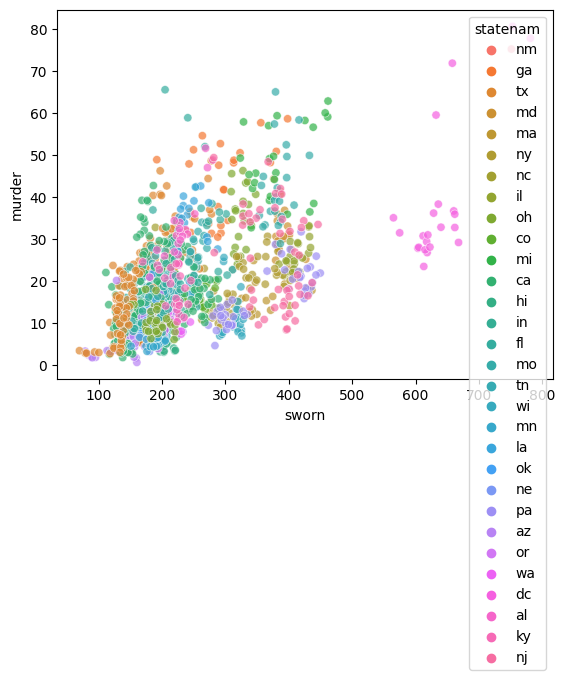

In [7]:
sns.scatterplot(data=df, x="sworn", y="murder", hue="statenam", alpha=.7)

<AxesSubplot:xlabel='year', ylabel='sworn'>

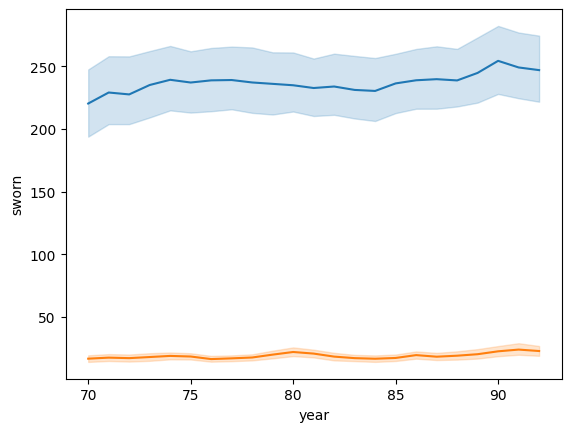

In [8]:
sns.lineplot(data=df, x="year", y="sworn")
sns.lineplot(data=df, x="year", y="murder")

## Election Cycle

- 経済が順調なとき、治安は世論調査で最も重要な論点とされることが多い
- 市長選において、現職者は犯罪抑制に取り組んでいることを示すインセンティブが生じる
  - 市長は警察を増強する権限がある
  - アメリカでは連邦、州、市などの自治体レベルでそれぞれ警察組織があり、Policeは市警察。連邦警察はFBIとかで麻薬など特定分野を専門とする
- 市長は経済問題に対して効果的に介入する権限を持たない
- 州政府は市政府へ予算を与えることができ、間接的な介入がありうる

In [9]:
# Δln Police と選挙（Nは一致、平均値がやや異なる）
pd.DataFrame({
    "Guvernatorial election": df.query("governor == 1")["d_sworn"],
    "Mayoral election": df.query("elecyear == 1")["d_sworn"],
    "No election": df.query("(governor == 0) & (elecyear == 0)")["d_sworn"],
}).describe().round(3)

,Guvernatorial election,Mayoral election,No election
count,302.000,391.000,621.000
mean,0.018,0.014,-0.003
std,0.063,0.064,0.057
min,-0.267,-0.286,-0.340
25%,-0.018,-0.021,-0.030
50%,0.010,0.008,-0.003
75%,0.047,0.038,0.028
max,0.338,0.366,0.290


## 共変量

選挙が、福祉や教育への支出を通じて、犯罪に影響を与えるパスが考えられる
そのパスを閉じるために共変量に追加する（p.279, Section Ⅲ冒頭）

## Section Ⅱ

### 警察官の数のモデル（First stage：Z → X）

$$
\Delta \ln P_{it} = \Theta_1 M_{it} + \Theta_2 G_{it}
+ \boldsymbol{X}_{it} \delta
+ \gamma_t + \lambda_i + \nu_{it}
$$

- $P_{it}$：都市$i$の$t$年の人口あたりの警察官の数の変化率
- $M_{it}$：市長選（mayoral election）の有無
- $G_{it}$：州知事選（gubernatorial election）の有無
- $\boldsymbol{X}_{it}$：共変量（デモグラフィック、州と地方の歳出、都市のサイズのindicator、地域ダミーと年ダミー）
- $\gamma_t$：説明はないが年の固定効果っぽい
- $\lambda_i$：説明はないが都市の固定効果っぽい


論文だとTable 2の(1) ~ (3)

コードだと`firststa.do`の240行あたり


### 犯罪件数のモデル（reduced form：Z→Y）

説明変数は一緒

論文だとTable 2の(4), (5)

Reduced formだとこの表記

$$
\Delta \ln C_{ijt} = \Psi_1 M_{it} + \Psi_2 G_{it}
+ \boldsymbol{X}_{it} \kappa_j
+ \gamma_{tj} + \lambda_i + \nu_{ijt}
$$

- $C_{ijt}$：都市$i$の$t$年の人口あたりの犯罪$j$の数の年間変化率
- $M_{it}$：市長選（mayoral election）の有無
- $G_{it}$：州知事選（gubernatorial election）の有無
- $\boldsymbol{X}_{it}$：共変量（デモグラフィック、州と地方の歳出、都市のサイズのindicator、地域ダミーと年ダミー）
- $\gamma_t$：説明はないが年の固定効果っぽい
- $\lambda_i$：説明はないが都市の固定効果っぽい

In [10]:
from stargazer.stargazer import Stargazer
import statsmodels.api as sm

# first stage
Stargazer([
    sm.OLS.from_formula(formula="d_sworn ~ elecyear + governor + year",
                        data=df.assign(year = lambda self: self.year.astype('category'))).fit(),
])

## 2SLS


$$
\Delta \ln C_{ijt} = 
  \beta_{1j} \Delta \ln P_{it}
+ \beta_{2j} \Delta \ln P_{it-1}
+ \boldsymbol{X}_{it} \eta_j
+ \gamma_{tj}
+ \lambda_i
+ \varepsilon_{ijt}
$$


In [11]:
df.columns

Index(['name', 'city', 'statenam', 'state', 'censdist', 'year', 'sworn',
       'civil', 'elecyear', 'governor', 'murder', 'rape', 'robbery', 'assault',
       'burglary', 'larceny', 'auto', 'rincpc', 'econgrow', 'unemp', 'citypop',
       'term2', 'term3', 'term4', 'a0_5', 'a5_9', 'a10_14', 'a15_19', 'a20_24',
       'a25_29', 'citybla', 'cityfemh', 'sta_educ', 'sta_welf', 'price',
       'termlim', 'd_sworn', 'd_murder', 'd_rape', 'd_robbery', 'd_assault',
       'd_burglary', 'd_larceny', 'd_auto', 'd_sta_educ', 'd_sta_welf',
       'citysize'],
      dtype='object')

In [13]:
from linearmodels.iv import IV2SLS
formula = "d_murder ~ [d_sworn ~ elecyear + governor] + citysize + d_sta_educ + d_sta_welf + unemp + a15_19 + a20_24 + citybla + cityfemh + citysize"
use_cols = formula.replace("~", " ").replace("[", " ").replace("]", " ").replace("+", " ").split()
model = IV2SLS.from_formula(
    formula=formula,
    data=df[use_cols].dropna()
).fit()
model

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:               d_murder   R-squared:                     -0.0166
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0239
No. Observations:                1258   F-statistic:                    21.231
Date:                Mon, Jul 31 2023   P-value (F-stat)                0.0117
Time:                        11:16:07   Distribution:                  chi2(9)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
citysize[citysize]     0.0021     0.0064     0.3239     0.7460     -0.0105      0.0147
d_sta_educ            -0.1929     0.3151    -0.6122     0.5404     -0.8105      0.4247
d_sta_welf            -0.0015     0.0453    -0.0335     0.9733     -0.0904      0.0874
unemp                 -0.9392     0.4773    -1.9677     0.0491     -1.8746     -0.0037
a15_19                -0.1820     0.9187    -0.1981     0.8430     -1.9827      1.6187
a20_24                 0.3402     0.7712     0.4411     0.6591     -1.1714      1.8518
citybla               -0.0006     0.0008    -0.8214     0.4114     -0.0021      0.0009
cityfemh               0.0046     0.0036     1.2739     0.2027     -0.0025      0.0116
d_sworn                1.0702     0.8825     1.2127     0.2252     -0.6594      2.7998
======================================================================================

Endogenous: d_sworn
Instruments: elecyear, governor
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7f638e097280